In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


Using TensorFlow backend.


In [2]:
print(train_data.shape) #데이터 하나당 13개의 수치적 특성이 담겨있다.(1인당 범죄율, 주택당 평균 방의 개수, 고속도로 접근성 등)
print(train_targets.shape) #주택의 가격은 1만에서 5만 달러 사이

(404, 13)
(404,)


## 데이터 정규화

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean #평균을 뺀다
std = train_data.std(axis=0)
train_data /= std #표준편차로 나눠줌

#테스트도 트레인 데이터를 이용해 나온 평균값과 표준편차를 이용해 정규화 작업을 해줘야한다.
test_data -= mean
test_data /= std

##  모델 구성

In [4]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae']) 
    return model

## K-겹 교차 검증

In [16]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k # 하나의 폴드에 얼마나 데이터가 있는지 값
num_epochs = 100
all_scores = []

for i in range(k):
    print("처리중인 폴드 #",i)
    #검증 데이터 뽑기
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] 
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    #학습 데이터 뽑기, 검증데이터가 아닌 나머지
    partial_train_data = np.concatenate( 
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose = 0) #verbose=0이면 훈련 과정이 출력되지않음 
    val_mse, val_mae = model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    
print(all_scores)
    

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
[3.3037071228027344, 3.0194125175476074, 3.419801950454712, 3.4640398025512695]


### 500epoch에 대한 학습

In [5]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k # 하나의 폴드에 얼마나 데이터가 있는지 값
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("처리중인 폴드 #",i)
    #검증 데이터 뽑기
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] 
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    #학습 데이터 뽑기, 검증데이터가 아닌 나머지
    partial_train_data = np.concatenate( 
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data = (val_data,val_targets),
                        epochs=num_epochs, batch_size=1, verbose = 0) #verbose=0이면 훈련 과정이 출력되지않음 
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [6]:
history.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

## 검증

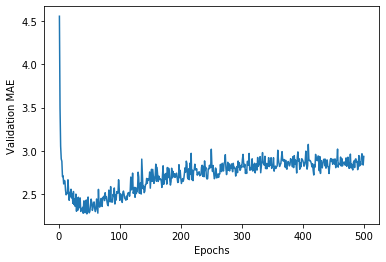

In [7]:
import matplotlib.pyplot as plt

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

epochs = range(1,len(average_mae_history)+1)

plt.plot(epochs,average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [8]:
def smooth_curve(points, factor=0.9): #지수 평균 곡선
    smoothed_points = []
    for point in points:
        if(smmothed_points):
            previous = smoothed_points[-1]
            smmothed_points.append(previous*factor + point*(1-factor)) #이전값과 현재값의 비율로 더해 그래프를 부드럽게 만든다
        else:
            smoothed_points.append(point)
            
    return smoothed_points